In [2]:
# import all the necessary libraries
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from segmentation_models_pytorch import Unet

import torch.optim as optim
from tqdm import tqdm


c:\Users\vinhn\anaconda3\envs\adl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA EXPLORATION

In [3]:
# get one sample folder:
sample_dir = r"C:\Users\vinhn\Downloads\BraTS_data\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_369"

# get the list of files in the sample folder
sample_files = os.listdir(sample_dir)
print("File names: ", sample_files)

# get the list of nifti files in the sample folder
for file in sample_files:
    if file.endswith("t1.nii"):
        t1_file = os.path.join(sample_dir, file)
    elif file.endswith("t1ce.nii"):
        t1ce_file = os.path.join(sample_dir, file)
    elif file.endswith("t2.nii"):
        t2_file = os.path.join(sample_dir, file)
    elif file.endswith("flair.nii"):
        flair_file = os.path.join(sample_dir, file)
    else:
        seg_file = os.path.join(sample_dir, file)

# load the nifti files
t1_img = nib.load(t1_file).get_fdata()
t1ce_img = nib.load(t1ce_file).get_fdata()
t2_img = nib.load(t2_file).get_fdata()
flair_img = nib.load(flair_file).get_fdata()
seg_img = nib.load(seg_file).get_fdata()

# get the shape of the data
print("Data shape: ", t1_img.shape, t1ce_img.shape, t2_img.shape, flair_img.shape, seg_img.shape)

# count number of samples in the sample folder
train_dir = r"C:\Users\vinhn\Downloads\BraTS_data\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"
val_dir = r"C:\Users\vinhn\Downloads\BraTS_data\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData"
train_samples = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]
val_samples = [folder for folder in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, folder))]
print("Number of folders in the sample folder: ", len(train_samples))
print("Number of folders in the validation folder: ", len(val_samples))



File names:  ['BraTS20_Training_369_flair.nii', 'BraTS20_Training_369_seg.nii', 'BraTS20_Training_369_t1.nii', 'BraTS20_Training_369_t1ce.nii', 'BraTS20_Training_369_t2.nii']
Data shape:  (240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155)
Number of folders in the sample folder:  369
Number of folders in the validation folder:  125


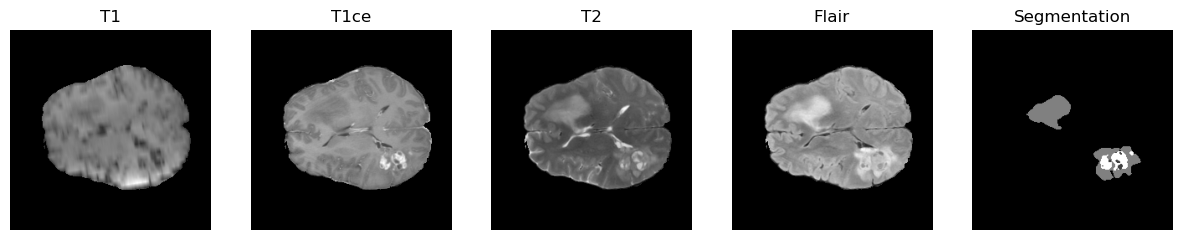

In [4]:
# show images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
titles = ["T1", "T1ce", "T2", "Flair", "Segmentation"]
images = [t1_img, t1ce_img, t2_img, flair_img, seg_img]
slice = t1_img.shape[2] // 2


for ax, title, img in zip(axes, titles, images):
    ax.imshow(img[:, :, slice], cmap="gray")
    ax.set_title(title)
    ax.axis("off")
    
plt.show()

# DATA PIPELINE

In [5]:
# build a transformation pipeline
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256)),
])

# define the transformation class
class BraTSDataset(Dataset):
    def __init__(self, data_dir, mode="train", transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.mode = mode
    
        # get the list of folders in the data directory
        self.samples = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample_dir = os.path.join(self.data_dir, self.samples[idx])
        sample_files = os.listdir(sample_dir)
        
        # get the list of nifti files in the sample folder
        for file in sample_files:
            if file.endswith("t1.nii"):
                t1_file = os.path.join(sample_dir, file)
            elif file.endswith("t1ce.nii"):
                t1ce_file = os.path.join(sample_dir, file)
            elif file.endswith("t2.nii"):
                t2_file = os.path.join(sample_dir, file)
            elif file.endswith("flair.nii"):
                flair_file = os.path.join(sample_dir, file)
            elif self.mode == "train":
                seg_file = os.path.join(sample_dir, file)
        
        slice = 155//2
        
        # load the nifti files
        t1_img = nib.load(t1_file).get_fdata()[:,:, slice]
        t1ce_img = nib.load(t1ce_file).get_fdata()[:,:, slice]
        t2_img = nib.load(t2_file).get_fdata()[:,:, slice]
        flair_img = nib.load(flair_file).get_fdata()[:,:, slice]
        if self.mode == "train":
            seg_img = nib.load(seg_file).get_fdata()[:,:, slice]
            seg_img = (seg_img > 0.5).astype(np.float32)
        else:
            # seg_img = nib.load(flair_file).get_fdata()[:,:, slice]
            seg_img = np.zeros_like(t1_img).astype(np.float32)

        sample = {
            "t1": t1_img,
            "t1ce": t1ce_img,
            "t2": t2_img,
            "flair": flair_img,
            "seg": seg_img
        }

        if self.mode == "train" and self.__len__() < 100:
             self.transform = transform_val
        
        if self.transform:
            for key in sample.keys():
                sample[key] = self.transform(sample[key])

        # Stack the modalities along the channel dimension
        modalities = ["t1", "t1ce", "t2", "flair"]
        stacked_input = torch.stack([torch.as_tensor(sample[modality], dtype=torch.float32).squeeze(0) for modality in modalities])
            
        output = {
            "input": stacked_input,
            "seg": sample['seg']
        }
        return output

In [6]:

train_dir = r"C:\Users\vinhn\Downloads\BraTS_data\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"
test_dir = r"C:\Users\vinhn\Downloads\BraTS_data\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData"
val_split_ratio = 0.15

train_dataset = BraTSDataset(train_dir, transform=transform_train, mode="train")
# Calculate sizes for training and validation datasets
train_size = int((1 - val_split_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the training dataset into train and validation sets
train_indices, val_indices = random_split(train_dataset, [train_size, val_size])

# Training subset with train transform
train_subset = torch.utils.data.Subset(train_dataset, train_indices.indices)
train_subset.dataset.transform = transform_train

# Validation subset with validation transform
val_subset = torch.utils.data.Subset(train_dataset, val_indices.indices)
val_subset.dataset.transform = transform_val

# Define DataLoaders for train and validation
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

test_dataset = BraTSDataset(test_dir, transform=transform_val, mode="test")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# SET UP MODEL & LOSS FUNCTION

In [ ]:
class U_Res_Net(nn.Module):
    def __init__(self, encoder_name="resnet34", in_channels=4, seg_classes=1):
        super(U_Res_Net, self).__init__()
        # Pretrained U-Net encoder
        self.unet = Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=seg_classes,
        )
        # Batch normalization
        self.batch_norm = nn.BatchNorm2d(4)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # normalize the input
        x = self.batch_norm(x)
        # pass through the U-Net
        seg_output = self.sigmoid(self.unet(x))
        return seg_output

    
# Instantiate and test
model = U_Res_Net(
    encoder_name="resnet34", 
    in_channels=4, 
    seg_classes=1, 
)


# # Test dummy input: 
# # Dummy input
# x = torch.rand(32, 4, 256, 256)  

# # Forward pass
# seg_output = model(x)

# # Output shapes
# print("Segmentation Output Shape:", seg_output.shape)


In [ ]:
# Loss function and IoU metric
bce = nn.BCELoss()

def IoU_score(output, target, smooth=1e-6):
    ep = 1e-6
    output_flatten = output.view(output.size(0), -1) > 0.5
    target_flatten = target.view(target.size(0), -1)

    # Compute intersection and union
    intersection = (output_flatten * target_flatten).sum(dim=1)
    union = (output_flatten + target_flatten).clamp(0, 1).sum(dim=1)

    # Compute IoU
    iou = (intersection + ep) / (union + ep)

    return iou.mean().cpu().numpy()

def combined_loss_fn(output, target, smooth=1e-6):
    ep = 1e-6
    
    bce_loss = bce(output, target)

    # flatten the tensors
    output = output.view(output.size(0), -1)
    target = target.view(target.size(0), -1)

    # Compute intersection and union
    intersection = (output * target).sum(dim=1)
    union = (output + target).sum(dim=1) - intersection

    # Compute IoU
    iou = (intersection + ep) / (union + ep)
    iou_loss = 1 - iou.mean()

    # Return mean IoU across the batch (on the same device)
    return bce_loss + iou_loss


# TRAINING

In [9]:
# Define the training loop
def train_unet(model, train_loader, val_loader, num_epochs, device, lr=1e-4):
    # Move the model to the device (GPU or CPU)
    model = model.to(device)

    train_combined_losses = []
    train_bce_losses = []
    train_iou_scores = []

    val_combined_losses = []
    val_bce_losses = []
    val_iou_scores = []

    best_error = np.inf
    counter = 0

    # Define the optimizer and loss functions
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCELoss()  # For binary segmentation

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()  # Set model to training mode
        train_bce_loss = 0
        train_combined_loss = 0
        train_iou_score = 0

        for batch in tqdm(train_loader, desc="Training"):
            inputs = batch["input"].to(device)  # Input images
            seg_targets = batch["seg"].to(device)  # Segmentation masks
            
            # Forward pass
            seg_output = model(inputs)
            
            # Compute losses per batch
            bce_loss = criterion(seg_output, seg_targets)
            combined_loss = combined_loss_fn(seg_output, seg_targets)
            iou_score = IoU_score(seg_output, seg_targets)
            
            # Backpropagation
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()
            
            # Compute losses per epoch
            train_combined_loss += combined_loss.item()
            train_bce_loss += bce_loss.item()
            train_iou_score += iou_score

        train_combined_loss /= len(train_loader)
        train_combined_losses.append(train_combined_loss)

        train_bce_loss /= len(train_loader)
        train_bce_losses.append(train_bce_loss)

        train_iou_score /= len(train_loader)
        train_iou_scores.append(train_iou_score)

        print(f"Training Combined Loss: {train_combined_loss:.4f} | Training BCE Loss: {train_bce_loss:.4f} | Train IoU Score: {train_iou_score:.4f}")
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_bce_loss = 0
        val_combined_loss = 0
        val_iou_score = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = batch["input"].to(device)
                seg_targets = batch["seg"].to(device)

                # Forward pass
                seg_output = model(inputs)

                # Compute losses per batch
                bce_loss = criterion(seg_output, seg_targets)
                combined_loss = combined_loss_fn(seg_output, seg_targets)
                iou_score = IoU_score(seg_output, seg_targets)


                # Compute losses per epoch
                val_bce_loss += bce_loss.item()
                val_combined_loss += combined_loss.item()
                val_iou_score += iou_score
        
        # append losses
        val_bce_loss /= len(val_loader)
        val_bce_losses.append(val_bce_loss)
        val_iou_score /= len(val_loader)
        val_iou_scores.append(val_iou_score)
        val_combined_loss /= len(val_loader)
        val_combined_losses.append(val_combined_loss)

        print(f"Val Combined Loss: {val_combined_loss:.4f} | Val BCE Loss: {val_bce_loss:.4f} | Total IoU Score: {val_iou_score:.4f}")

        iou_loss = val_combined_loss - val_bce_loss

        # Save the best model
        if epoch > 100:
            if  iou_loss < best_error:
                best_error = iou_loss
                torch.save(model.state_dict(), "best_model.pth")
                print("Model saved!")
                counter = 0

            # Early stopping
            if iou_loss > best_error:
                counter += 1
                if counter > 15:
                    print("Early stopping!")
                    break
    
    print("Training completed.")
    model.load_state_dict(torch.load("best_model.pth"))

    return train_bce_losses, train_iou_scores, train_combined_losses, val_bce_losses, val_iou_scores, val_combined_losses


In [10]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_bce_losses, train_iou_scores, train_combined_losses, val_bce_losses, val_iou_scores, val_combined_losses = train_unet(model=model, train_loader=train_loader,
                                                                                                                             val_loader=val_loader,num_epochs=200, 
                                                                                                                             device=device,lr=1e-4)

Epoch 1/200


Training: 100%|██████████| 5/5 [01:35<00:00, 19.09s/it]


Training Combined Loss: 1.9869 | Training BCE Loss: 1.0184 | Train IoU Score: 0.0291


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.42s/it]


Val Combined Loss: 2.5341 | Val BCE Loss: 1.5636 | Total IoU Score: 0.0240
Epoch 2/200


Training: 100%|██████████| 5/5 [01:21<00:00, 16.29s/it]


Training Combined Loss: 1.8049 | Training BCE Loss: 0.8380 | Train IoU Score: 0.0352


Validation: 100%|██████████| 1/1 [00:11<00:00, 11.76s/it]


Val Combined Loss: 2.3742 | Val BCE Loss: 1.4080 | Total IoU Score: 0.0338
Epoch 3/200


Training: 100%|██████████| 5/5 [01:04<00:00, 12.83s/it]


Training Combined Loss: 1.7268 | Training BCE Loss: 0.7611 | Train IoU Score: 0.0494


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Val Combined Loss: 1.9846 | Val BCE Loss: 1.0199 | Total IoU Score: 0.0454
Epoch 4/200


Training: 100%|██████████| 5/5 [00:48<00:00,  9.79s/it]


Training Combined Loss: 1.6679 | Training BCE Loss: 0.7046 | Train IoU Score: 0.0693


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Val Combined Loss: 1.7332 | Val BCE Loss: 0.7718 | Total IoU Score: 0.0683
Epoch 5/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.15s/it]


Training Combined Loss: 1.6164 | Training BCE Loss: 0.6571 | Train IoU Score: 0.0909


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


Val Combined Loss: 1.8136 | Val BCE Loss: 0.8552 | Total IoU Score: 0.0870
Epoch 6/200


Training: 100%|██████████| 5/5 [01:24<00:00, 16.90s/it]


Training Combined Loss: 1.5824 | Training BCE Loss: 0.6257 | Train IoU Score: 0.1262


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.41s/it]


Val Combined Loss: 1.8496 | Val BCE Loss: 0.8942 | Total IoU Score: 0.1090
Epoch 7/200


Training: 100%|██████████| 5/5 [01:24<00:00, 16.88s/it]


Training Combined Loss: 1.5276 | Training BCE Loss: 0.5768 | Train IoU Score: 0.1602


Validation: 100%|██████████| 1/1 [00:17<00:00, 17.22s/it]


Val Combined Loss: 1.6401 | Val BCE Loss: 0.6880 | Total IoU Score: 0.1449
Epoch 8/200


Training: 100%|██████████| 5/5 [01:23<00:00, 16.78s/it]


Training Combined Loss: 1.4948 | Training BCE Loss: 0.5481 | Train IoU Score: 0.2019


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.20s/it]


Val Combined Loss: 1.5273 | Val BCE Loss: 0.5774 | Total IoU Score: 0.1903
Epoch 9/200


Training: 100%|██████████| 5/5 [01:16<00:00, 15.31s/it]


Training Combined Loss: 1.4683 | Training BCE Loss: 0.5249 | Train IoU Score: 0.2333


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.60s/it]


Val Combined Loss: 1.5292 | Val BCE Loss: 0.5808 | Total IoU Score: 0.2380
Epoch 10/200


Training: 100%|██████████| 5/5 [01:23<00:00, 16.68s/it]


Training Combined Loss: 1.4175 | Training BCE Loss: 0.4793 | Train IoU Score: 0.2938


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.83s/it]


Val Combined Loss: 1.4334 | Val BCE Loss: 0.4883 | Total IoU Score: 0.2908
Epoch 11/200


Training: 100%|██████████| 5/5 [01:24<00:00, 16.86s/it]


Training Combined Loss: 1.3797 | Training BCE Loss: 0.4443 | Train IoU Score: 0.3237


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.26s/it]


Val Combined Loss: 1.3910 | Val BCE Loss: 0.4495 | Total IoU Score: 0.3213
Epoch 12/200


Training: 100%|██████████| 5/5 [01:24<00:00, 16.90s/it]


Training Combined Loss: 1.3633 | Training BCE Loss: 0.4300 | Train IoU Score: 0.3607


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.18s/it]


Val Combined Loss: 1.3553 | Val BCE Loss: 0.4176 | Total IoU Score: 0.3458
Epoch 13/200


Training: 100%|██████████| 5/5 [01:26<00:00, 17.35s/it]


Training Combined Loss: 1.3452 | Training BCE Loss: 0.4148 | Train IoU Score: 0.3835


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.78s/it]


Val Combined Loss: 1.3355 | Val BCE Loss: 0.4004 | Total IoU Score: 0.3523
Epoch 14/200


Training: 100%|██████████| 5/5 [01:22<00:00, 16.43s/it]


Training Combined Loss: 1.3288 | Training BCE Loss: 0.4009 | Train IoU Score: 0.4076


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.02s/it]


Val Combined Loss: 1.3188 | Val BCE Loss: 0.3830 | Total IoU Score: 0.3749
Epoch 15/200


Training: 100%|██████████| 5/5 [01:23<00:00, 16.63s/it]


Training Combined Loss: 1.3265 | Training BCE Loss: 0.3992 | Train IoU Score: 0.4260


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.39s/it]


Val Combined Loss: 1.3754 | Val BCE Loss: 0.4399 | Total IoU Score: 0.3754
Epoch 16/200


Training: 100%|██████████| 5/5 [01:22<00:00, 16.43s/it]


Training Combined Loss: 1.3206 | Training BCE Loss: 0.3961 | Train IoU Score: 0.4414


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.27s/it]


Val Combined Loss: 1.5445 | Val BCE Loss: 0.6113 | Total IoU Score: 0.3904
Epoch 17/200


Training: 100%|██████████| 5/5 [01:23<00:00, 16.73s/it]


Training Combined Loss: 1.2988 | Training BCE Loss: 0.3762 | Train IoU Score: 0.4645


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.72s/it]


Val Combined Loss: 1.3989 | Val BCE Loss: 0.4652 | Total IoU Score: 0.3963
Epoch 18/200


Training: 100%|██████████| 5/5 [01:23<00:00, 16.71s/it]


Training Combined Loss: 1.2881 | Training BCE Loss: 0.3669 | Train IoU Score: 0.4872


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.38s/it]


Val Combined Loss: 1.3981 | Val BCE Loss: 0.4691 | Total IoU Score: 0.4095
Epoch 19/200


Training: 100%|██████████| 5/5 [01:21<00:00, 16.39s/it]


Training Combined Loss: 1.2694 | Training BCE Loss: 0.3508 | Train IoU Score: 0.4887


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.58s/it]


Val Combined Loss: 1.3222 | Val BCE Loss: 0.3961 | Total IoU Score: 0.4179
Epoch 20/200


Training: 100%|██████████| 5/5 [01:22<00:00, 16.48s/it]


Training Combined Loss: 1.2728 | Training BCE Loss: 0.3547 | Train IoU Score: 0.5122


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it]


Val Combined Loss: 1.2711 | Val BCE Loss: 0.3435 | Total IoU Score: 0.4189
Epoch 21/200


Training: 100%|██████████| 5/5 [01:25<00:00, 17.04s/it]


Training Combined Loss: 1.2537 | Training BCE Loss: 0.3379 | Train IoU Score: 0.5247


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.80s/it]


Val Combined Loss: 1.2435 | Val BCE Loss: 0.3199 | Total IoU Score: 0.4400
Epoch 22/200


Training: 100%|██████████| 5/5 [01:23<00:00, 16.76s/it]


Training Combined Loss: 1.2355 | Training BCE Loss: 0.3213 | Train IoU Score: 0.5588


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.99s/it]


Val Combined Loss: 1.2357 | Val BCE Loss: 0.3140 | Total IoU Score: 0.4297
Epoch 23/200


Training: 100%|██████████| 5/5 [01:25<00:00, 17.08s/it]


Training Combined Loss: 1.2362 | Training BCE Loss: 0.3231 | Train IoU Score: 0.6297


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.58s/it]


Val Combined Loss: 1.2297 | Val BCE Loss: 0.3093 | Total IoU Score: 0.5500
Epoch 24/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.62s/it]


Training Combined Loss: 1.2208 | Training BCE Loss: 0.3104 | Train IoU Score: 0.6284


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.85s/it]


Val Combined Loss: 1.2252 | Val BCE Loss: 0.3048 | Total IoU Score: 0.5904
Epoch 25/200


Training: 100%|██████████| 5/5 [01:22<00:00, 16.41s/it]


Training Combined Loss: 1.2170 | Training BCE Loss: 0.3077 | Train IoU Score: 0.6658


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.13s/it]


Val Combined Loss: 1.2182 | Val BCE Loss: 0.2993 | Total IoU Score: 0.6016
Epoch 26/200


Training: 100%|██████████| 5/5 [01:23<00:00, 16.75s/it]


Training Combined Loss: 1.2176 | Training BCE Loss: 0.3100 | Train IoU Score: 0.6588


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.82s/it]


Val Combined Loss: 1.2087 | Val BCE Loss: 0.2901 | Total IoU Score: 0.6061
Epoch 27/200


Training: 100%|██████████| 5/5 [01:24<00:00, 16.80s/it]


Training Combined Loss: 1.2036 | Training BCE Loss: 0.2976 | Train IoU Score: 0.6532


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.70s/it]


Val Combined Loss: 1.2022 | Val BCE Loss: 0.2859 | Total IoU Score: 0.6157
Epoch 28/200


Training: 100%|██████████| 5/5 [01:20<00:00, 16.06s/it]


Training Combined Loss: 1.1885 | Training BCE Loss: 0.2838 | Train IoU Score: 0.6795


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.08s/it]


Val Combined Loss: 1.1964 | Val BCE Loss: 0.2840 | Total IoU Score: 0.5941
Epoch 29/200


Training: 100%|██████████| 5/5 [01:20<00:00, 16.20s/it]


Training Combined Loss: 1.1863 | Training BCE Loss: 0.2835 | Train IoU Score: 0.6772


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.52s/it]


Val Combined Loss: 1.1887 | Val BCE Loss: 0.2755 | Total IoU Score: 0.6286
Epoch 30/200


Training: 100%|██████████| 5/5 [01:22<00:00, 16.43s/it]


Training Combined Loss: 1.1808 | Training BCE Loss: 0.2795 | Train IoU Score: 0.7005


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.24s/it]


Val Combined Loss: 1.1847 | Val BCE Loss: 0.2774 | Total IoU Score: 0.6021
Epoch 31/200


Training: 100%|██████████| 5/5 [01:07<00:00, 13.45s/it]


Training Combined Loss: 1.1701 | Training BCE Loss: 0.2711 | Train IoU Score: 0.6906


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.92s/it]


Val Combined Loss: 1.1759 | Val BCE Loss: 0.2655 | Total IoU Score: 0.6426
Epoch 32/200


Training: 100%|██████████| 5/5 [01:14<00:00, 14.91s/it]


Training Combined Loss: 1.1581 | Training BCE Loss: 0.2608 | Train IoU Score: 0.6946


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.02s/it]


Val Combined Loss: 1.1683 | Val BCE Loss: 0.2613 | Total IoU Score: 0.6272
Epoch 33/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.97s/it]


Training Combined Loss: 1.1543 | Training BCE Loss: 0.2578 | Train IoU Score: 0.7144


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.46s/it]


Val Combined Loss: 1.1622 | Val BCE Loss: 0.2577 | Total IoU Score: 0.6233
Epoch 34/200


Training: 100%|██████████| 5/5 [01:22<00:00, 16.40s/it]


Training Combined Loss: 1.1516 | Training BCE Loss: 0.2577 | Train IoU Score: 0.7074


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.36s/it]


Val Combined Loss: 1.1549 | Val BCE Loss: 0.2519 | Total IoU Score: 0.6174
Epoch 35/200


Training: 100%|██████████| 5/5 [01:20<00:00, 16.12s/it]


Training Combined Loss: 1.1406 | Training BCE Loss: 0.2483 | Train IoU Score: 0.7321


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.78s/it]


Val Combined Loss: 1.1492 | Val BCE Loss: 0.2451 | Total IoU Score: 0.6420
Epoch 36/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.86s/it]


Training Combined Loss: 1.1365 | Training BCE Loss: 0.2459 | Train IoU Score: 0.7312


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.87s/it]


Val Combined Loss: 1.1440 | Val BCE Loss: 0.2441 | Total IoU Score: 0.6608
Epoch 37/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.73s/it]


Training Combined Loss: 1.1240 | Training BCE Loss: 0.2352 | Train IoU Score: 0.7355


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.43s/it]


Val Combined Loss: 1.1395 | Val BCE Loss: 0.2394 | Total IoU Score: 0.6515
Epoch 38/200


Training: 100%|██████████| 5/5 [01:17<00:00, 15.58s/it]


Training Combined Loss: 1.1314 | Training BCE Loss: 0.2418 | Train IoU Score: 0.6939


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.70s/it]


Val Combined Loss: 1.1355 | Val BCE Loss: 0.2416 | Total IoU Score: 0.6094
Epoch 39/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.88s/it]


Training Combined Loss: 1.1210 | Training BCE Loss: 0.2349 | Train IoU Score: 0.6919


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


Val Combined Loss: 2.1744 | Val BCE Loss: 1.2808 | Total IoU Score: 0.5514
Epoch 40/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.95s/it]


Training Combined Loss: 1.1228 | Training BCE Loss: 0.2358 | Train IoU Score: 0.7030


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


Val Combined Loss: 1.5596 | Val BCE Loss: 0.6661 | Total IoU Score: 0.5811
Epoch 41/200


Training: 100%|██████████| 5/5 [01:15<00:00, 15.08s/it]


Training Combined Loss: 1.1229 | Training BCE Loss: 0.2367 | Train IoU Score: 0.6551


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.60s/it]


Val Combined Loss: 1.1295 | Val BCE Loss: 0.2355 | Total IoU Score: 0.5892
Epoch 42/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.67s/it]


Training Combined Loss: 1.1131 | Training BCE Loss: 0.2285 | Train IoU Score: 0.6796


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]


Val Combined Loss: 1.1491 | Val BCE Loss: 0.2539 | Total IoU Score: 0.6237
Epoch 43/200


Training: 100%|██████████| 5/5 [01:22<00:00, 16.44s/it]


Training Combined Loss: 1.1009 | Training BCE Loss: 0.2180 | Train IoU Score: 0.7046


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.61s/it]


Val Combined Loss: 1.1145 | Val BCE Loss: 0.2254 | Total IoU Score: 0.5892
Epoch 44/200


Training: 100%|██████████| 5/5 [01:27<00:00, 17.49s/it]


Training Combined Loss: 1.0947 | Training BCE Loss: 0.2164 | Train IoU Score: 0.6977


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.54s/it]


Val Combined Loss: 1.1086 | Val BCE Loss: 0.2124 | Total IoU Score: 0.6170
Epoch 45/200


Training: 100%|██████████| 5/5 [01:25<00:00, 17.12s/it]


Training Combined Loss: 1.0852 | Training BCE Loss: 0.2071 | Train IoU Score: 0.6916


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.50s/it]


Val Combined Loss: 1.0958 | Val BCE Loss: 0.2076 | Total IoU Score: 0.6369
Epoch 46/200


Training: 100%|██████████| 5/5 [01:28<00:00, 17.61s/it]


Training Combined Loss: 1.0792 | Training BCE Loss: 0.2037 | Train IoU Score: 0.7220


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.32s/it]


Val Combined Loss: 1.0964 | Val BCE Loss: 0.2089 | Total IoU Score: 0.6405
Epoch 47/200


Training: 100%|██████████| 5/5 [01:28<00:00, 17.79s/it]


Training Combined Loss: 1.0788 | Training BCE Loss: 0.2052 | Train IoU Score: 0.6969


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.75s/it]


Val Combined Loss: 1.0858 | Val BCE Loss: 0.2005 | Total IoU Score: 0.6137
Epoch 48/200


Training: 100%|██████████| 5/5 [01:15<00:00, 15.04s/it]


Training Combined Loss: 1.0655 | Training BCE Loss: 0.1949 | Train IoU Score: 0.7328


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.06s/it]


Val Combined Loss: 1.0805 | Val BCE Loss: 0.1985 | Total IoU Score: 0.6068
Epoch 49/200


Training: 100%|██████████| 5/5 [01:14<00:00, 14.88s/it]


Training Combined Loss: 1.0652 | Training BCE Loss: 0.1958 | Train IoU Score: 0.7207


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.11s/it]


Val Combined Loss: 1.0775 | Val BCE Loss: 0.1957 | Total IoU Score: 0.6256
Epoch 50/200


Training: 100%|██████████| 5/5 [01:14<00:00, 14.94s/it]


Training Combined Loss: 1.0594 | Training BCE Loss: 0.1929 | Train IoU Score: 0.7350


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.49s/it]


Val Combined Loss: 1.0717 | Val BCE Loss: 0.1945 | Total IoU Score: 0.6243
Epoch 51/200


Training: 100%|██████████| 5/5 [01:20<00:00, 16.18s/it]


Training Combined Loss: 1.0548 | Training BCE Loss: 0.1897 | Train IoU Score: 0.7354


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.60s/it]


Val Combined Loss: 1.1001 | Val BCE Loss: 0.2223 | Total IoU Score: 0.6252
Epoch 52/200


Training: 100%|██████████| 5/5 [01:21<00:00, 16.27s/it]


Training Combined Loss: 1.0449 | Training BCE Loss: 0.1815 | Train IoU Score: 0.7653


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.66s/it]


Val Combined Loss: 1.0648 | Val BCE Loss: 0.1933 | Total IoU Score: 0.6214
Epoch 53/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.94s/it]


Training Combined Loss: 1.0459 | Training BCE Loss: 0.1865 | Train IoU Score: 0.7429


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.09s/it]


Val Combined Loss: 1.0675 | Val BCE Loss: 0.1937 | Total IoU Score: 0.6694
Epoch 54/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.62s/it]


Training Combined Loss: 1.0362 | Training BCE Loss: 0.1786 | Train IoU Score: 0.7525


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.25s/it]


Val Combined Loss: 1.0607 | Val BCE Loss: 0.1875 | Total IoU Score: 0.6437
Epoch 55/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.62s/it]


Training Combined Loss: 1.0308 | Training BCE Loss: 0.1741 | Train IoU Score: 0.7608


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


Val Combined Loss: 1.0463 | Val BCE Loss: 0.1778 | Total IoU Score: 0.6512
Epoch 56/200


Training: 100%|██████████| 5/5 [01:02<00:00, 12.58s/it]


Training Combined Loss: 1.0233 | Training BCE Loss: 0.1710 | Train IoU Score: 0.7490


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.99s/it]


Val Combined Loss: 1.0417 | Val BCE Loss: 0.1741 | Total IoU Score: 0.6842
Epoch 57/200


Training: 100%|██████████| 5/5 [01:16<00:00, 15.26s/it]


Training Combined Loss: 1.0192 | Training BCE Loss: 0.1690 | Train IoU Score: 0.7408


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.23s/it]


Val Combined Loss: 1.0376 | Val BCE Loss: 0.1710 | Total IoU Score: 0.6788
Epoch 58/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.96s/it]


Training Combined Loss: 1.0203 | Training BCE Loss: 0.1726 | Train IoU Score: 0.7609


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.95s/it]


Val Combined Loss: 1.0323 | Val BCE Loss: 0.1685 | Total IoU Score: 0.6393
Epoch 59/200


Training: 100%|██████████| 5/5 [01:21<00:00, 16.35s/it]


Training Combined Loss: 1.0114 | Training BCE Loss: 0.1674 | Train IoU Score: 0.7599


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.52s/it]


Val Combined Loss: 1.0306 | Val BCE Loss: 0.1677 | Total IoU Score: 0.6599
Epoch 60/200


Training: 100%|██████████| 5/5 [01:16<00:00, 15.38s/it]


Training Combined Loss: 1.0069 | Training BCE Loss: 0.1657 | Train IoU Score: 0.7573


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.20s/it]


Val Combined Loss: 1.0292 | Val BCE Loss: 0.1691 | Total IoU Score: 0.6475
Epoch 61/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.91s/it]


Training Combined Loss: 0.9989 | Training BCE Loss: 0.1603 | Train IoU Score: 0.7760


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


Val Combined Loss: 1.0237 | Val BCE Loss: 0.1720 | Total IoU Score: 0.6063
Epoch 62/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.97s/it]


Training Combined Loss: 1.0023 | Training BCE Loss: 0.1678 | Train IoU Score: 0.7120


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


Val Combined Loss: 1.0230 | Val BCE Loss: 0.1663 | Total IoU Score: 0.6646
Epoch 63/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.70s/it]


Training Combined Loss: 0.9927 | Training BCE Loss: 0.1574 | Train IoU Score: 0.7874


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.63s/it]


Val Combined Loss: 1.0124 | Val BCE Loss: 0.1643 | Total IoU Score: 0.6732
Epoch 64/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.76s/it]


Training Combined Loss: 0.9867 | Training BCE Loss: 0.1591 | Train IoU Score: 0.7452


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


Val Combined Loss: 1.0129 | Val BCE Loss: 0.1620 | Total IoU Score: 0.6921
Epoch 65/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.77s/it]


Training Combined Loss: 0.9751 | Training BCE Loss: 0.1498 | Train IoU Score: 0.7811


Validation: 100%|██████████| 1/1 [00:15<00:00, 15.10s/it]


Val Combined Loss: 1.0095 | Val BCE Loss: 0.1617 | Total IoU Score: 0.6633
Epoch 66/200


Training: 100%|██████████| 5/5 [01:19<00:00, 15.86s/it]


Training Combined Loss: 0.9706 | Training BCE Loss: 0.1488 | Train IoU Score: 0.7659


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.25s/it]


Val Combined Loss: 1.0019 | Val BCE Loss: 0.1579 | Total IoU Score: 0.6735
Epoch 67/200


Training: 100%|██████████| 5/5 [01:21<00:00, 16.35s/it]


Training Combined Loss: 0.9687 | Training BCE Loss: 0.1488 | Train IoU Score: 0.7809


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


Val Combined Loss: 1.0036 | Val BCE Loss: 0.1587 | Total IoU Score: 0.6770
Epoch 68/200


Training: 100%|██████████| 5/5 [01:20<00:00, 16.19s/it]


Training Combined Loss: 0.9629 | Training BCE Loss: 0.1479 | Train IoU Score: 0.7800


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.26s/it]


Val Combined Loss: 1.0009 | Val BCE Loss: 0.1569 | Total IoU Score: 0.6937
Epoch 69/200


Training: 100%|██████████| 5/5 [01:17<00:00, 15.45s/it]


Training Combined Loss: 0.9587 | Training BCE Loss: 0.1460 | Train IoU Score: 0.7852


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.26s/it]


Val Combined Loss: 0.9956 | Val BCE Loss: 0.1613 | Total IoU Score: 0.6426
Epoch 70/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.69s/it]


Training Combined Loss: 0.9538 | Training BCE Loss: 0.1454 | Train IoU Score: 0.7742


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.80s/it]


Val Combined Loss: 0.9871 | Val BCE Loss: 0.1518 | Total IoU Score: 0.6594
Epoch 71/200


Training: 100%|██████████| 5/5 [01:17<00:00, 15.41s/it]


Training Combined Loss: 0.9445 | Training BCE Loss: 0.1389 | Train IoU Score: 0.7677


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.06s/it]


Val Combined Loss: 0.9861 | Val BCE Loss: 0.1514 | Total IoU Score: 0.6630
Epoch 72/200


Training: 100%|██████████| 5/5 [01:18<00:00, 15.78s/it]


Training Combined Loss: 0.9384 | Training BCE Loss: 0.1351 | Train IoU Score: 0.8011


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.21s/it]


Val Combined Loss: 0.9771 | Val BCE Loss: 0.1480 | Total IoU Score: 0.6621
Epoch 73/200


Training: 100%|██████████| 5/5 [01:21<00:00, 16.25s/it]


Training Combined Loss: 0.9360 | Training BCE Loss: 0.1392 | Train IoU Score: 0.7734


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


Val Combined Loss: 0.9807 | Val BCE Loss: 0.1492 | Total IoU Score: 0.6825
Epoch 74/200


Training: 100%|██████████| 5/5 [01:20<00:00, 16.12s/it]


Training Combined Loss: 0.9259 | Training BCE Loss: 0.1322 | Train IoU Score: 0.8003


Validation: 100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


Val Combined Loss: 0.9692 | Val BCE Loss: 0.1445 | Total IoU Score: 0.6833
Epoch 75/200


Training: 100%|██████████| 5/5 [01:20<00:00, 16.18s/it]


Training Combined Loss: 0.9217 | Training BCE Loss: 0.1332 | Train IoU Score: 0.7878


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.19s/it]


Val Combined Loss: 0.9604 | Val BCE Loss: 0.1405 | Total IoU Score: 0.6735
Epoch 76/200


Training: 100%|██████████| 5/5 [01:14<00:00, 14.95s/it]


Training Combined Loss: 0.9144 | Training BCE Loss: 0.1298 | Train IoU Score: 0.8071


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.82s/it]


Val Combined Loss: 0.9523 | Val BCE Loss: 0.1377 | Total IoU Score: 0.6818
Epoch 77/200


Training: 100%|██████████| 5/5 [01:16<00:00, 15.20s/it]


Training Combined Loss: 0.9051 | Training BCE Loss: 0.1262 | Train IoU Score: 0.7938


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.56s/it]


Val Combined Loss: 0.9479 | Val BCE Loss: 0.1361 | Total IoU Score: 0.6702
Epoch 78/200


Training: 100%|██████████| 5/5 [01:16<00:00, 15.24s/it]


Training Combined Loss: 0.9012 | Training BCE Loss: 0.1233 | Train IoU Score: 0.7908


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.98s/it]


Val Combined Loss: 0.9524 | Val BCE Loss: 0.1364 | Total IoU Score: 0.6784
Epoch 79/200


Training: 100%|██████████| 5/5 [01:16<00:00, 15.21s/it]


Training Combined Loss: 0.8929 | Training BCE Loss: 0.1200 | Train IoU Score: 0.7745


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.95s/it]


Val Combined Loss: 0.9465 | Val BCE Loss: 0.1357 | Total IoU Score: 0.6712
Epoch 80/200


Training: 100%|██████████| 5/5 [01:14<00:00, 14.83s/it]


Training Combined Loss: 0.8904 | Training BCE Loss: 0.1230 | Train IoU Score: 0.7951


Validation: 100%|██████████| 1/1 [00:13<00:00, 13.38s/it]


Val Combined Loss: 0.9420 | Val BCE Loss: 0.1365 | Total IoU Score: 0.6708
Epoch 81/200


Training: 100%|██████████| 5/5 [01:10<00:00, 14.02s/it]


Training Combined Loss: 0.8792 | Training BCE Loss: 0.1168 | Train IoU Score: 0.8148


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.80s/it]


Val Combined Loss: 0.9332 | Val BCE Loss: 0.1329 | Total IoU Score: 0.6805
Epoch 82/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.48s/it]


Training Combined Loss: 0.8812 | Training BCE Loss: 0.1232 | Train IoU Score: 0.8045


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Val Combined Loss: 0.9251 | Val BCE Loss: 0.1297 | Total IoU Score: 0.6987
Epoch 83/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.27s/it]


Training Combined Loss: 0.8751 | Training BCE Loss: 0.1206 | Train IoU Score: 0.8132


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Val Combined Loss: 0.9145 | Val BCE Loss: 0.1270 | Total IoU Score: 0.6869
Epoch 84/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.48s/it]


Training Combined Loss: 0.8657 | Training BCE Loss: 0.1177 | Train IoU Score: 0.7859


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.92s/it]


Val Combined Loss: 0.9213 | Val BCE Loss: 0.1273 | Total IoU Score: 0.6789
Epoch 85/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.47s/it]


Training Combined Loss: 0.8578 | Training BCE Loss: 0.1095 | Train IoU Score: 0.8072


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Val Combined Loss: 0.9116 | Val BCE Loss: 0.1234 | Total IoU Score: 0.6838
Epoch 86/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.51s/it]


Training Combined Loss: 0.8541 | Training BCE Loss: 0.1114 | Train IoU Score: 0.7948


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Val Combined Loss: 0.9118 | Val BCE Loss: 0.1253 | Total IoU Score: 0.6831
Epoch 87/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.60s/it]


Training Combined Loss: 0.8480 | Training BCE Loss: 0.1098 | Train IoU Score: 0.8276


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


Val Combined Loss: 0.8994 | Val BCE Loss: 0.1209 | Total IoU Score: 0.6764
Epoch 88/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.52s/it]


Training Combined Loss: 0.8409 | Training BCE Loss: 0.1074 | Train IoU Score: 0.8121


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


Val Combined Loss: 0.8957 | Val BCE Loss: 0.1184 | Total IoU Score: 0.6869
Epoch 89/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.44s/it]


Training Combined Loss: 0.8331 | Training BCE Loss: 0.1033 | Train IoU Score: 0.8145


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


Val Combined Loss: 0.8887 | Val BCE Loss: 0.1166 | Total IoU Score: 0.6808
Epoch 90/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.56s/it]


Training Combined Loss: 0.8251 | Training BCE Loss: 0.1012 | Train IoU Score: 0.8170


Validation: 100%|██████████| 1/1 [00:08<00:00,  9.00s/it]


Val Combined Loss: 0.8806 | Val BCE Loss: 0.1161 | Total IoU Score: 0.6817
Epoch 91/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.54s/it]


Training Combined Loss: 0.8209 | Training BCE Loss: 0.0994 | Train IoU Score: 0.8170


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Val Combined Loss: 0.8802 | Val BCE Loss: 0.1150 | Total IoU Score: 0.6925
Epoch 92/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Training Combined Loss: 0.8160 | Training BCE Loss: 0.0983 | Train IoU Score: 0.8161


Validation: 100%|██████████| 1/1 [00:10<00:00, 10.93s/it]


Val Combined Loss: 0.8777 | Val BCE Loss: 0.1144 | Total IoU Score: 0.6470
Epoch 93/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.26s/it]


Training Combined Loss: 0.8097 | Training BCE Loss: 0.0976 | Train IoU Score: 0.8084


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


Val Combined Loss: 0.8742 | Val BCE Loss: 0.1126 | Total IoU Score: 0.6980
Epoch 94/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


Training Combined Loss: 0.8073 | Training BCE Loss: 0.0951 | Train IoU Score: 0.8104


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Val Combined Loss: 0.8675 | Val BCE Loss: 0.1110 | Total IoU Score: 0.6412
Epoch 95/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.41s/it]


Training Combined Loss: 0.7998 | Training BCE Loss: 0.0949 | Train IoU Score: 0.8288


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


Val Combined Loss: 0.8624 | Val BCE Loss: 0.1093 | Total IoU Score: 0.6672
Epoch 96/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.40s/it]


Training Combined Loss: 0.7965 | Training BCE Loss: 0.0945 | Train IoU Score: 0.8091


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.92s/it]


Val Combined Loss: 0.8590 | Val BCE Loss: 0.1096 | Total IoU Score: 0.6765
Epoch 97/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.29s/it]


Training Combined Loss: 0.7896 | Training BCE Loss: 0.0915 | Train IoU Score: 0.8159


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


Val Combined Loss: 0.8515 | Val BCE Loss: 0.1042 | Total IoU Score: 0.6820
Epoch 98/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.31s/it]


Training Combined Loss: 0.7820 | Training BCE Loss: 0.0883 | Train IoU Score: 0.8156


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


Val Combined Loss: 0.8411 | Val BCE Loss: 0.1047 | Total IoU Score: 0.6612
Epoch 99/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Training Combined Loss: 0.7765 | Training BCE Loss: 0.0900 | Train IoU Score: 0.8277


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Val Combined Loss: 0.8396 | Val BCE Loss: 0.1028 | Total IoU Score: 0.6663
Epoch 100/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.14s/it]


Training Combined Loss: 0.7701 | Training BCE Loss: 0.0862 | Train IoU Score: 0.8271


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Val Combined Loss: 0.8267 | Val BCE Loss: 0.0975 | Total IoU Score: 0.6957
Epoch 101/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.43s/it]


Training Combined Loss: 0.7655 | Training BCE Loss: 0.0856 | Train IoU Score: 0.8358


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.84s/it]


Val Combined Loss: 0.8309 | Val BCE Loss: 0.1034 | Total IoU Score: 0.6642
Epoch 102/200


Training: 100%|██████████| 5/5 [00:54<00:00, 10.86s/it]


Training Combined Loss: 0.7609 | Training BCE Loss: 0.0856 | Train IoU Score: 0.8030


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


Val Combined Loss: 0.8328 | Val BCE Loss: 0.1006 | Total IoU Score: 0.6739
Model saved!
Epoch 103/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.40s/it]


Training Combined Loss: 0.7583 | Training BCE Loss: 0.0851 | Train IoU Score: 0.8172


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.90s/it]


Val Combined Loss: 0.8214 | Val BCE Loss: 0.0968 | Total IoU Score: 0.6750
Model saved!
Epoch 104/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.24s/it]


Training Combined Loss: 0.7517 | Training BCE Loss: 0.0821 | Train IoU Score: 0.8190


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.71s/it]


Val Combined Loss: 0.8194 | Val BCE Loss: 0.0992 | Total IoU Score: 0.6831
Model saved!
Epoch 105/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.27s/it]


Training Combined Loss: 0.7454 | Training BCE Loss: 0.0810 | Train IoU Score: 0.8125


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.39s/it]


Val Combined Loss: 0.8172 | Val BCE Loss: 0.0987 | Total IoU Score: 0.6465
Model saved!
Epoch 106/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


Training Combined Loss: 0.7387 | Training BCE Loss: 0.0794 | Train IoU Score: 0.8087


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.83s/it]


Val Combined Loss: 0.8014 | Val BCE Loss: 0.0928 | Total IoU Score: 0.6688
Model saved!
Epoch 107/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


Training Combined Loss: 0.7353 | Training BCE Loss: 0.0784 | Train IoU Score: 0.8249


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


Val Combined Loss: 0.7908 | Val BCE Loss: 0.0877 | Total IoU Score: 0.7019
Model saved!
Epoch 108/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.45s/it]


Training Combined Loss: 0.7299 | Training BCE Loss: 0.0766 | Train IoU Score: 0.8310


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


Val Combined Loss: 0.8038 | Val BCE Loss: 0.0973 | Total IoU Score: 0.6621
Epoch 109/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.53s/it]


Training Combined Loss: 0.7265 | Training BCE Loss: 0.0790 | Train IoU Score: 0.8227


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Val Combined Loss: 0.8096 | Val BCE Loss: 0.0944 | Total IoU Score: 0.6941
Epoch 110/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.18s/it]


Training Combined Loss: 0.7271 | Training BCE Loss: 0.0755 | Train IoU Score: 0.7848


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Val Combined Loss: 0.7955 | Val BCE Loss: 0.0865 | Total IoU Score: 0.6414
Epoch 111/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.56s/it]


Training Combined Loss: 0.7191 | Training BCE Loss: 0.0735 | Train IoU Score: 0.8288


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Val Combined Loss: 0.7779 | Val BCE Loss: 0.0846 | Total IoU Score: 0.6861
Model saved!
Epoch 112/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.41s/it]


Training Combined Loss: 0.7109 | Training BCE Loss: 0.0745 | Train IoU Score: 0.8312


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.83s/it]


Val Combined Loss: 0.7904 | Val BCE Loss: 0.0871 | Total IoU Score: 0.7032
Epoch 113/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.54s/it]


Training Combined Loss: 0.7057 | Training BCE Loss: 0.0722 | Train IoU Score: 0.8343


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Val Combined Loss: 0.7840 | Val BCE Loss: 0.0845 | Total IoU Score: 0.6979
Epoch 114/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.47s/it]


Training Combined Loss: 0.7018 | Training BCE Loss: 0.0730 | Train IoU Score: 0.8283


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.12s/it]


Val Combined Loss: 0.7839 | Val BCE Loss: 0.0873 | Total IoU Score: 0.7049
Epoch 115/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.54s/it]


Training Combined Loss: 0.6932 | Training BCE Loss: 0.0707 | Train IoU Score: 0.8339


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Val Combined Loss: 0.7690 | Val BCE Loss: 0.0845 | Total IoU Score: 0.6888
Model saved!
Epoch 116/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.26s/it]


Training Combined Loss: 0.6895 | Training BCE Loss: 0.0680 | Train IoU Score: 0.8249


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.83s/it]


Val Combined Loss: 0.7627 | Val BCE Loss: 0.0818 | Total IoU Score: 0.6697
Model saved!
Epoch 117/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.32s/it]


Training Combined Loss: 0.6829 | Training BCE Loss: 0.0678 | Train IoU Score: 0.8290


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


Val Combined Loss: 0.7560 | Val BCE Loss: 0.0810 | Total IoU Score: 0.6979
Model saved!
Epoch 118/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.26s/it]


Training Combined Loss: 0.6825 | Training BCE Loss: 0.0673 | Train IoU Score: 0.8031


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


Val Combined Loss: 0.7649 | Val BCE Loss: 0.0832 | Total IoU Score: 0.6704
Epoch 119/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.11s/it]


Training Combined Loss: 0.6757 | Training BCE Loss: 0.0661 | Train IoU Score: 0.8411


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.80s/it]


Val Combined Loss: 0.7579 | Val BCE Loss: 0.0806 | Total IoU Score: 0.6979
Epoch 120/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.22s/it]


Training Combined Loss: 0.6709 | Training BCE Loss: 0.0659 | Train IoU Score: 0.8342


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


Val Combined Loss: 0.7581 | Val BCE Loss: 0.0800 | Total IoU Score: 0.6552
Epoch 121/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.29s/it]


Training Combined Loss: 0.6646 | Training BCE Loss: 0.0641 | Train IoU Score: 0.8260


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


Val Combined Loss: 0.7417 | Val BCE Loss: 0.0757 | Total IoU Score: 0.7110
Model saved!
Epoch 122/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.20s/it]


Training Combined Loss: 0.6588 | Training BCE Loss: 0.0626 | Train IoU Score: 0.8397


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


Val Combined Loss: 0.7426 | Val BCE Loss: 0.0760 | Total IoU Score: 0.7095
Epoch 123/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.21s/it]


Training Combined Loss: 0.6538 | Training BCE Loss: 0.0617 | Train IoU Score: 0.8412


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


Val Combined Loss: 0.7567 | Val BCE Loss: 0.0808 | Total IoU Score: 0.6812
Epoch 124/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.52s/it]


Training Combined Loss: 0.6494 | Training BCE Loss: 0.0607 | Train IoU Score: 0.8530


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


Val Combined Loss: 0.7365 | Val BCE Loss: 0.0735 | Total IoU Score: 0.6796
Model saved!
Epoch 125/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.53s/it]


Training Combined Loss: 0.6453 | Training BCE Loss: 0.0591 | Train IoU Score: 0.8268


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


Val Combined Loss: 0.7506 | Val BCE Loss: 0.0801 | Total IoU Score: 0.6910
Epoch 126/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.43s/it]


Training Combined Loss: 0.6410 | Training BCE Loss: 0.0602 | Train IoU Score: 0.8429


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


Val Combined Loss: 0.7284 | Val BCE Loss: 0.0731 | Total IoU Score: 0.6769
Model saved!
Epoch 127/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


Training Combined Loss: 0.6361 | Training BCE Loss: 0.0592 | Train IoU Score: 0.8263


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.82s/it]


Val Combined Loss: 0.7358 | Val BCE Loss: 0.0749 | Total IoU Score: 0.6917
Epoch 128/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.32s/it]


Training Combined Loss: 0.6290 | Training BCE Loss: 0.0568 | Train IoU Score: 0.8488


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Val Combined Loss: 0.7226 | Val BCE Loss: 0.0738 | Total IoU Score: 0.7082
Model saved!
Epoch 129/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.40s/it]


Training Combined Loss: 0.6264 | Training BCE Loss: 0.0579 | Train IoU Score: 0.8446


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


Val Combined Loss: 0.7202 | Val BCE Loss: 0.0705 | Total IoU Score: 0.6626
Epoch 130/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.53s/it]


Training Combined Loss: 0.6214 | Training BCE Loss: 0.0559 | Train IoU Score: 0.8405


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Val Combined Loss: 0.7193 | Val BCE Loss: 0.0707 | Total IoU Score: 0.6966
Model saved!
Epoch 131/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.34s/it]


Training Combined Loss: 0.6174 | Training BCE Loss: 0.0554 | Train IoU Score: 0.8570


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Val Combined Loss: 0.7118 | Val BCE Loss: 0.0703 | Total IoU Score: 0.6650
Model saved!
Epoch 132/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.36s/it]


Training Combined Loss: 0.6110 | Training BCE Loss: 0.0543 | Train IoU Score: 0.8464


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.88s/it]


Val Combined Loss: 0.7077 | Val BCE Loss: 0.0666 | Total IoU Score: 0.6742
Model saved!
Epoch 133/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


Training Combined Loss: 0.6067 | Training BCE Loss: 0.0542 | Train IoU Score: 0.8551


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


Val Combined Loss: 0.6988 | Val BCE Loss: 0.0655 | Total IoU Score: 0.6978
Model saved!
Epoch 134/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.44s/it]


Training Combined Loss: 0.6021 | Training BCE Loss: 0.0528 | Train IoU Score: 0.8588


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


Val Combined Loss: 0.6904 | Val BCE Loss: 0.0658 | Total IoU Score: 0.6944
Model saved!
Epoch 135/200


Training: 100%|██████████| 5/5 [00:55<00:00, 11.20s/it]


Training Combined Loss: 0.5962 | Training BCE Loss: 0.0531 | Train IoU Score: 0.8363


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


Val Combined Loss: 0.7005 | Val BCE Loss: 0.0655 | Total IoU Score: 0.6789
Epoch 136/200


Training: 100%|██████████| 5/5 [00:54<00:00, 10.98s/it]


Training Combined Loss: 0.5927 | Training BCE Loss: 0.0499 | Train IoU Score: 0.8582


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


Val Combined Loss: 0.6819 | Val BCE Loss: 0.0598 | Total IoU Score: 0.6679
Model saved!
Epoch 137/200


Training: 100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


Training Combined Loss: 0.5894 | Training BCE Loss: 0.0518 | Train IoU Score: 0.8508


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.29s/it]


Val Combined Loss: 0.6853 | Val BCE Loss: 0.0622 | Total IoU Score: 0.6702
Epoch 138/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.48s/it]


Training Combined Loss: 0.5841 | Training BCE Loss: 0.0498 | Train IoU Score: 0.8582


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.93s/it]


Val Combined Loss: 0.6951 | Val BCE Loss: 0.0632 | Total IoU Score: 0.6977
Epoch 139/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.29s/it]


Training Combined Loss: 0.5815 | Training BCE Loss: 0.0506 | Train IoU Score: 0.8509


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


Val Combined Loss: 0.7015 | Val BCE Loss: 0.0667 | Total IoU Score: 0.6757
Epoch 140/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


Training Combined Loss: 0.5767 | Training BCE Loss: 0.0479 | Train IoU Score: 0.8520


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Val Combined Loss: 0.6925 | Val BCE Loss: 0.0609 | Total IoU Score: 0.6874
Epoch 141/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.36s/it]


Training Combined Loss: 0.5731 | Training BCE Loss: 0.0468 | Train IoU Score: 0.8584


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.36s/it]


Val Combined Loss: 0.6922 | Val BCE Loss: 0.0651 | Total IoU Score: 0.6695
Epoch 142/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.56s/it]


Training Combined Loss: 0.5699 | Training BCE Loss: 0.0484 | Train IoU Score: 0.8343


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


Val Combined Loss: 0.7005 | Val BCE Loss: 0.0662 | Total IoU Score: 0.6730
Epoch 143/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.18s/it]


Training Combined Loss: 0.5664 | Training BCE Loss: 0.0474 | Train IoU Score: 0.8563


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Val Combined Loss: 0.6961 | Val BCE Loss: 0.0646 | Total IoU Score: 0.6780
Epoch 144/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Training Combined Loss: 0.5605 | Training BCE Loss: 0.0463 | Train IoU Score: 0.8465


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


Val Combined Loss: 0.6628 | Val BCE Loss: 0.0571 | Total IoU Score: 0.6824
Model saved!
Epoch 145/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.36s/it]


Training Combined Loss: 0.5535 | Training BCE Loss: 0.0452 | Train IoU Score: 0.8550


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Val Combined Loss: 0.6662 | Val BCE Loss: 0.0585 | Total IoU Score: 0.7136
Epoch 146/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Training Combined Loss: 0.5510 | Training BCE Loss: 0.0452 | Train IoU Score: 0.8516


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


Val Combined Loss: 0.6695 | Val BCE Loss: 0.0590 | Total IoU Score: 0.6901
Epoch 147/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


Training Combined Loss: 0.5465 | Training BCE Loss: 0.0439 | Train IoU Score: 0.8392


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


Val Combined Loss: 0.6694 | Val BCE Loss: 0.0627 | Total IoU Score: 0.7239
Epoch 148/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.50s/it]


Training Combined Loss: 0.5414 | Training BCE Loss: 0.0445 | Train IoU Score: 0.8623


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


Val Combined Loss: 0.6586 | Val BCE Loss: 0.0581 | Total IoU Score: 0.7089
Model saved!
Epoch 149/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


Training Combined Loss: 0.5399 | Training BCE Loss: 0.0425 | Train IoU Score: 0.8573


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


Val Combined Loss: 0.6531 | Val BCE Loss: 0.0569 | Total IoU Score: 0.7208
Model saved!
Epoch 150/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.45s/it]


Training Combined Loss: 0.5343 | Training BCE Loss: 0.0419 | Train IoU Score: 0.8635


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


Val Combined Loss: 0.6560 | Val BCE Loss: 0.0582 | Total IoU Score: 0.6885
Epoch 151/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.28s/it]


Training Combined Loss: 0.5296 | Training BCE Loss: 0.0421 | Train IoU Score: 0.8572


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


Val Combined Loss: 0.6381 | Val BCE Loss: 0.0531 | Total IoU Score: 0.6892
Model saved!
Epoch 152/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.32s/it]


Training Combined Loss: 0.5246 | Training BCE Loss: 0.0399 | Train IoU Score: 0.8601


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Val Combined Loss: 0.6801 | Val BCE Loss: 0.0650 | Total IoU Score: 0.6926
Epoch 153/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.49s/it]


Training Combined Loss: 0.5183 | Training BCE Loss: 0.0408 | Train IoU Score: 0.8728


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


Val Combined Loss: 0.6571 | Val BCE Loss: 0.0586 | Total IoU Score: 0.6734
Epoch 154/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


Training Combined Loss: 0.5191 | Training BCE Loss: 0.0407 | Train IoU Score: 0.8472


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.88s/it]


Val Combined Loss: 0.6625 | Val BCE Loss: 0.0599 | Total IoU Score: 0.7016
Epoch 155/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.54s/it]


Training Combined Loss: 0.5155 | Training BCE Loss: 0.0401 | Train IoU Score: 0.8557


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.10s/it]


Val Combined Loss: 0.6497 | Val BCE Loss: 0.0565 | Total IoU Score: 0.6911
Epoch 156/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


Training Combined Loss: 0.5114 | Training BCE Loss: 0.0386 | Train IoU Score: 0.8567


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Val Combined Loss: 0.6351 | Val BCE Loss: 0.0523 | Total IoU Score: 0.6923
Model saved!
Epoch 157/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.49s/it]


Training Combined Loss: 0.5089 | Training BCE Loss: 0.0401 | Train IoU Score: 0.8573


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.83s/it]


Val Combined Loss: 0.6688 | Val BCE Loss: 0.0609 | Total IoU Score: 0.7220
Epoch 158/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.36s/it]


Training Combined Loss: 0.5088 | Training BCE Loss: 0.0394 | Train IoU Score: 0.8511


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Val Combined Loss: 0.6880 | Val BCE Loss: 0.0675 | Total IoU Score: 0.6964
Epoch 159/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Training Combined Loss: 0.5084 | Training BCE Loss: 0.0395 | Train IoU Score: 0.8521


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.90s/it]


Val Combined Loss: 0.6832 | Val BCE Loss: 0.0650 | Total IoU Score: 0.6790
Epoch 160/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.35s/it]


Training Combined Loss: 0.5030 | Training BCE Loss: 0.0392 | Train IoU Score: 0.8500


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.27s/it]


Val Combined Loss: 0.6768 | Val BCE Loss: 0.0630 | Total IoU Score: 0.6932
Epoch 161/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.47s/it]


Training Combined Loss: 0.4996 | Training BCE Loss: 0.0382 | Train IoU Score: 0.8520


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


Val Combined Loss: 0.6268 | Val BCE Loss: 0.0499 | Total IoU Score: 0.6996
Model saved!
Epoch 162/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


Training Combined Loss: 0.4947 | Training BCE Loss: 0.0364 | Train IoU Score: 0.8538


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.82s/it]


Val Combined Loss: 0.6425 | Val BCE Loss: 0.0568 | Total IoU Score: 0.6737
Epoch 163/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


Training Combined Loss: 0.4895 | Training BCE Loss: 0.0369 | Train IoU Score: 0.8571


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Val Combined Loss: 0.6232 | Val BCE Loss: 0.0532 | Total IoU Score: 0.7034
Model saved!
Epoch 164/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.27s/it]


Training Combined Loss: 0.4858 | Training BCE Loss: 0.0360 | Train IoU Score: 0.8505


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Val Combined Loss: 0.6403 | Val BCE Loss: 0.0567 | Total IoU Score: 0.6900
Epoch 165/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.28s/it]


Training Combined Loss: 0.4821 | Training BCE Loss: 0.0346 | Train IoU Score: 0.8539


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


Val Combined Loss: 0.6330 | Val BCE Loss: 0.0526 | Total IoU Score: 0.6500
Epoch 166/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.49s/it]


Training Combined Loss: 0.4798 | Training BCE Loss: 0.0357 | Train IoU Score: 0.8444


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


Val Combined Loss: 0.6144 | Val BCE Loss: 0.0473 | Total IoU Score: 0.6965
Model saved!
Epoch 167/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.34s/it]


Training Combined Loss: 0.4751 | Training BCE Loss: 0.0345 | Train IoU Score: 0.8573


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


Val Combined Loss: 0.6137 | Val BCE Loss: 0.0490 | Total IoU Score: 0.6861
Model saved!
Epoch 168/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.39s/it]


Training Combined Loss: 0.4713 | Training BCE Loss: 0.0356 | Train IoU Score: 0.8414


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


Val Combined Loss: 0.6333 | Val BCE Loss: 0.0554 | Total IoU Score: 0.6753
Epoch 169/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.24s/it]


Training Combined Loss: 0.4695 | Training BCE Loss: 0.0348 | Train IoU Score: 0.8639


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


Val Combined Loss: 0.6274 | Val BCE Loss: 0.0524 | Total IoU Score: 0.7041
Epoch 170/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.26s/it]


Training Combined Loss: 0.4628 | Training BCE Loss: 0.0319 | Train IoU Score: 0.8596


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


Val Combined Loss: 0.6065 | Val BCE Loss: 0.0491 | Total IoU Score: 0.6919
Model saved!
Epoch 171/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


Training Combined Loss: 0.4619 | Training BCE Loss: 0.0332 | Train IoU Score: 0.8518


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Val Combined Loss: 0.6042 | Val BCE Loss: 0.0485 | Total IoU Score: 0.6216
Model saved!
Epoch 172/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Training Combined Loss: 0.4557 | Training BCE Loss: 0.0321 | Train IoU Score: 0.8522


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Val Combined Loss: 0.5860 | Val BCE Loss: 0.0430 | Total IoU Score: 0.7164
Model saved!
Epoch 173/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.28s/it]


Training Combined Loss: 0.4530 | Training BCE Loss: 0.0308 | Train IoU Score: 0.8674


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.93s/it]


Val Combined Loss: 0.5995 | Val BCE Loss: 0.0474 | Total IoU Score: 0.7048
Epoch 174/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


Training Combined Loss: 0.4463 | Training BCE Loss: 0.0322 | Train IoU Score: 0.8737


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Val Combined Loss: 0.5840 | Val BCE Loss: 0.0476 | Total IoU Score: 0.6720
Model saved!
Epoch 175/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


Training Combined Loss: 0.4462 | Training BCE Loss: 0.0319 | Train IoU Score: 0.8369


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Val Combined Loss: 0.6069 | Val BCE Loss: 0.0521 | Total IoU Score: 0.6480
Epoch 176/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.26s/it]


Training Combined Loss: 0.4407 | Training BCE Loss: 0.0301 | Train IoU Score: 0.8595


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


Val Combined Loss: 0.5959 | Val BCE Loss: 0.0488 | Total IoU Score: 0.7098
Epoch 177/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.15s/it]


Training Combined Loss: 0.4359 | Training BCE Loss: 0.0297 | Train IoU Score: 0.8589


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.66s/it]


Val Combined Loss: 0.6139 | Val BCE Loss: 0.0487 | Total IoU Score: 0.6733
Epoch 178/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Training Combined Loss: 0.4340 | Training BCE Loss: 0.0300 | Train IoU Score: 0.8592


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Val Combined Loss: 0.6020 | Val BCE Loss: 0.0481 | Total IoU Score: 0.7265
Epoch 179/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.34s/it]


Training Combined Loss: 0.4323 | Training BCE Loss: 0.0289 | Train IoU Score: 0.8601


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.83s/it]


Val Combined Loss: 0.6192 | Val BCE Loss: 0.0511 | Total IoU Score: 0.7065
Epoch 180/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.42s/it]


Training Combined Loss: 0.4245 | Training BCE Loss: 0.0289 | Train IoU Score: 0.8687


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Val Combined Loss: 0.5987 | Val BCE Loss: 0.0500 | Total IoU Score: 0.7097
Epoch 181/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


Training Combined Loss: 0.4243 | Training BCE Loss: 0.0294 | Train IoU Score: 0.8749


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


Val Combined Loss: 0.5980 | Val BCE Loss: 0.0472 | Total IoU Score: 0.6843
Epoch 182/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.32s/it]


Training Combined Loss: 0.4166 | Training BCE Loss: 0.0280 | Train IoU Score: 0.8835


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


Val Combined Loss: 0.5779 | Val BCE Loss: 0.0428 | Total IoU Score: 0.6560
Model saved!
Epoch 183/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.39s/it]


Training Combined Loss: 0.4132 | Training BCE Loss: 0.0272 | Train IoU Score: 0.8715


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


Val Combined Loss: 0.5619 | Val BCE Loss: 0.0411 | Total IoU Score: 0.6795
Model saved!
Epoch 184/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.11s/it]


Training Combined Loss: 0.4105 | Training BCE Loss: 0.0265 | Train IoU Score: 0.8842


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Val Combined Loss: 0.5790 | Val BCE Loss: 0.0447 | Total IoU Score: 0.6607
Epoch 185/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.19s/it]


Training Combined Loss: 0.4078 | Training BCE Loss: 0.0280 | Train IoU Score: 0.8834


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


Val Combined Loss: 0.6093 | Val BCE Loss: 0.0505 | Total IoU Score: 0.6579
Epoch 186/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.08s/it]


Training Combined Loss: 0.4029 | Training BCE Loss: 0.0267 | Train IoU Score: 0.8818


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.52s/it]


Val Combined Loss: 0.5741 | Val BCE Loss: 0.0440 | Total IoU Score: 0.6670
Epoch 187/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.08s/it]


Training Combined Loss: 0.4011 | Training BCE Loss: 0.0266 | Train IoU Score: 0.8737


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Val Combined Loss: 0.5820 | Val BCE Loss: 0.0445 | Total IoU Score: 0.6688
Epoch 188/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.20s/it]


Training Combined Loss: 0.3971 | Training BCE Loss: 0.0260 | Train IoU Score: 0.8881


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Val Combined Loss: 0.5721 | Val BCE Loss: 0.0437 | Total IoU Score: 0.6804
Epoch 189/200


Training: 100%|██████████| 5/5 [00:50<00:00, 10.16s/it]


Training Combined Loss: 0.3949 | Training BCE Loss: 0.0264 | Train IoU Score: 0.8864


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Val Combined Loss: 0.5797 | Val BCE Loss: 0.0446 | Total IoU Score: 0.6577
Epoch 190/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


Training Combined Loss: 0.3933 | Training BCE Loss: 0.0250 | Train IoU Score: 0.8821


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


Val Combined Loss: 0.5571 | Val BCE Loss: 0.0428 | Total IoU Score: 0.6682
Model saved!
Epoch 191/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


Training Combined Loss: 0.3919 | Training BCE Loss: 0.0246 | Train IoU Score: 0.8860


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Val Combined Loss: 0.5809 | Val BCE Loss: 0.0464 | Total IoU Score: 0.6802
Epoch 192/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.35s/it]


Training Combined Loss: 0.3889 | Training BCE Loss: 0.0255 | Train IoU Score: 0.8870


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.88s/it]


Val Combined Loss: 0.5782 | Val BCE Loss: 0.0455 | Total IoU Score: 0.6944
Epoch 193/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.26s/it]


Training Combined Loss: 0.3858 | Training BCE Loss: 0.0257 | Train IoU Score: 0.8797


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Val Combined Loss: 0.5603 | Val BCE Loss: 0.0426 | Total IoU Score: 0.6457
Epoch 194/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.24s/it]


Training Combined Loss: 0.3836 | Training BCE Loss: 0.0239 | Train IoU Score: 0.8761


Validation: 100%|██████████| 1/1 [00:08<00:00,  9.00s/it]


Val Combined Loss: 0.5369 | Val BCE Loss: 0.0417 | Total IoU Score: 0.6736
Model saved!
Epoch 195/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.20s/it]


Training Combined Loss: 0.3889 | Training BCE Loss: 0.0270 | Train IoU Score: 0.8724


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Val Combined Loss: 0.6224 | Val BCE Loss: 0.0561 | Total IoU Score: 0.6680
Epoch 196/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.35s/it]


Training Combined Loss: 0.3790 | Training BCE Loss: 0.0247 | Train IoU Score: 0.8795


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]


Val Combined Loss: 0.5792 | Val BCE Loss: 0.0475 | Total IoU Score: 0.7107
Epoch 197/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.40s/it]


Training Combined Loss: 0.3754 | Training BCE Loss: 0.0234 | Train IoU Score: 0.8878


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.04s/it]


Val Combined Loss: 0.5748 | Val BCE Loss: 0.0465 | Total IoU Score: 0.6963
Epoch 198/200


Training: 100%|██████████| 5/5 [00:51<00:00, 10.29s/it]


Training Combined Loss: 0.3723 | Training BCE Loss: 0.0232 | Train IoU Score: 0.8741


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Val Combined Loss: 0.5521 | Val BCE Loss: 0.0436 | Total IoU Score: 0.6755
Epoch 199/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.41s/it]


Training Combined Loss: 0.3722 | Training BCE Loss: 0.0238 | Train IoU Score: 0.8811


Validation: 100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


Val Combined Loss: 0.5704 | Val BCE Loss: 0.0461 | Total IoU Score: 0.6709
Epoch 200/200


Training: 100%|██████████| 5/5 [00:52<00:00, 10.44s/it]


Training Combined Loss: 0.3679 | Training BCE Loss: 0.0229 | Train IoU Score: 0.8845


Validation: 100%|██████████| 1/1 [00:08<00:00,  8.96s/it]

Val Combined Loss: 0.5469 | Val BCE Loss: 0.0418 | Total IoU Score: 0.6837
Training completed.



C:\Users\vinhn\AppData\Local\Temp\ipykernel_22668\2643493671.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


# EVALUATION

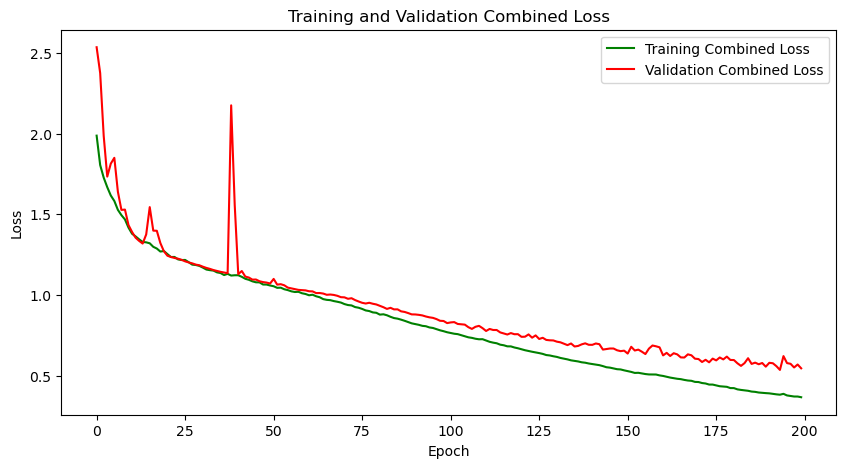

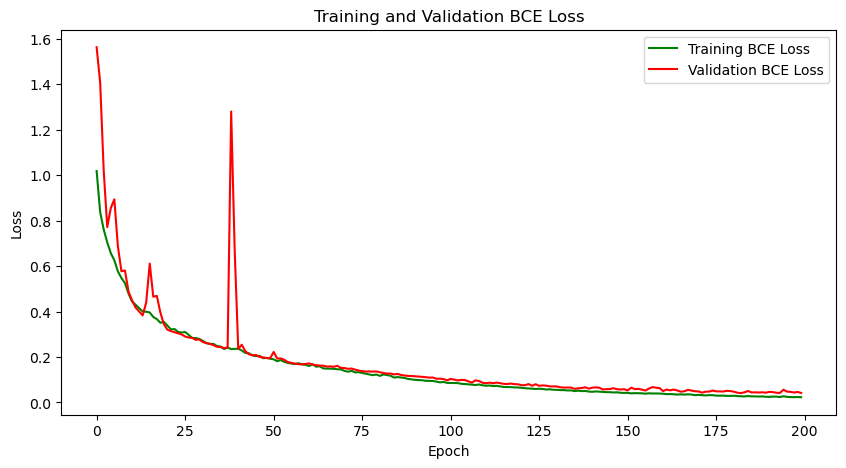

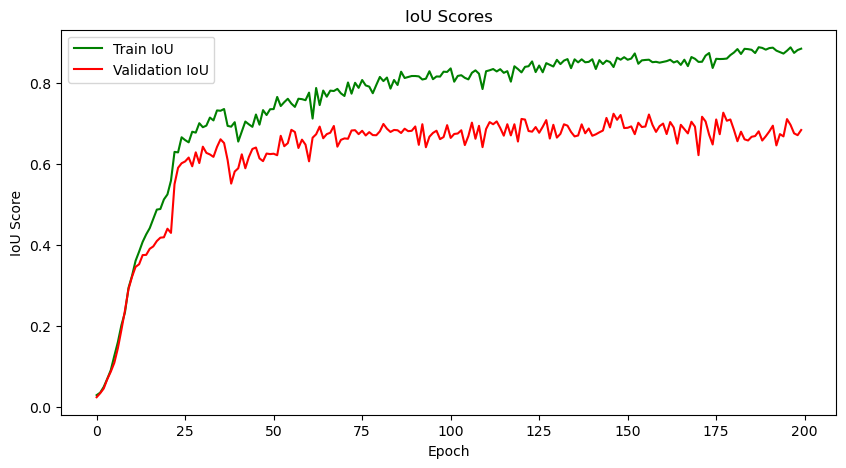

In [11]:
# Plot Training and Validation Loss
train_bce_losses, train_iou_scores, train_combined_losses, val_bce_losses, val_iou_scores, val_combined_losses

# visualize combined losses
plt.figure(figsize=(10, 5))
plt.plot(train_combined_losses, label="Training Combined Loss", color="green")
plt.plot(val_combined_losses, label="Validation Combined Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Combined Loss")
plt.legend()
plt.show()

# visualize BCE losses
plt.figure(figsize=(10, 5))
plt.plot(train_bce_losses, label="Training BCE Loss", color="green")
plt.plot(val_bce_losses, label="Validation BCE Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation BCE Loss")
plt.legend()
plt.show()

# Plot Validation IoU
plt.figure(figsize=(10, 5))
plt.plot(train_iou_scores, label="Train IoU", color="green")
plt.plot(val_iou_scores, label="Validation IoU", color="red")
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.title("IoU Scores")
plt.legend()
plt.show()


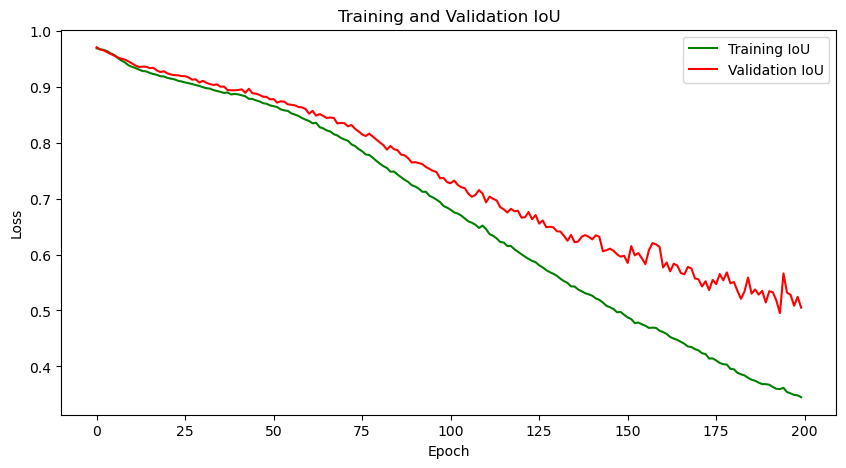

In [49]:
train_iou_2 = np.array(train_combined_losses) - np.array(train_bce_losses)
val_iou_2 = np.array(val_combined_losses) - np.array(val_bce_losses)

# visualize combined losses
plt.figure(figsize=(10, 5))
plt.plot(train_iou_2, label="Training IoU", color="green")
plt.plot(val_iou_2, label="Validation IoU", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation IoU")
plt.legend()
plt.show()


In [45]:
def visualize_predictions(inputs, seg_targets, seg_outputs, batch_idx, mode):
    """Visualize the input, ground truth, and predicted segmentation."""
    if mode == "with_mask":
        num_cols = 5
    else:
        num_cols = 3

    num_images = min(inputs.shape[0], 4)  # Visualize up to 4 images
    fig, axes = plt.subplots(num_images, num_cols, figsize=(12, num_images * 4))
    
    for i in range(num_images):
        # input_image = inputs[i, 1].cpu().numpy()  # Use the first channel for visualization
        input_image_flair = inputs[i, 3].cpu().numpy()  # Use the first channel for visualization

        ground_truth = seg_targets[i, 0].cpu().numpy()

        # prediction = torch.sigmoid(seg_outputs[i, 0]).cpu().numpy()  # Apply sigmoid and move to CPU
        threshold = 0.5
        binary_prediction = (seg_outputs[i, 0].cpu().numpy() > threshold)
        # ground_truth = (ground_truth > threshold)  # Binarize ground truth

        axes[i, 0].imshow(input_image_flair, cmap="gray")
        axes[i, 0].set_title("Flair")
        axes[i, 0].axis("off")
        
        axes[i, (num_cols//2)].imshow(binary_prediction, cmap="Blues", alpha=0.4)
        axes[i, (num_cols//2)].set_title("Prediction")
        axes[i, (num_cols//2)].axis("off")

        axes[i, (num_cols//2 + 1)].imshow(input_image_flair, cmap="gray")
        axes[i, (num_cols//2 + 1)].imshow(binary_prediction, cmap="Blues", alpha=0.8)
        axes[i, (num_cols//2 + 1)].set_title("Flair + Prediction")
        axes[i, (num_cols//2 + 1)].axis("off")

        if mode == "with_mask":
            axes[i, 1].imshow(ground_truth, cmap="jet", alpha=0.8)
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis("off")

            axes[i, 4].imshow(ground_truth, cmap="prism", alpha=0.6)
            axes[i, 4].imshow(binary_prediction, cmap="Blues", alpha = 0.6)
            axes[i, 4].set_title("Groud Truth +  Prediction")
            axes[i, 4].axis("off")

    
    plt.tight_layout()
    plt.savefig(f"batch_{batch_idx}_visualization.png")
    plt.show()


# Test the model
def test_and_visualize(model, test_loader, device, mode="without_mask"):
    model = model.to(device)
    model.eval()
    criterion = nn.BCELoss()

    test_bce_loss = 0
    test_combined_loss = 0
    test_iou_score = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Testing")):
            inputs = batch["input"].to(device)
            seg_targets = batch["seg"].to(device)
            
            # Forward pass
            seg_outputs = model(inputs)

            # Compute losses
            loss = criterion(seg_outputs, seg_targets)
            combined_loss = combined_loss_fn(seg_outputs, seg_targets)
            iou_score = IoU_score(seg_outputs, seg_targets)

            test_bce_loss += loss.item()
            test_combined_loss += combined_loss.item()
            test_iou_score += iou_score

            # Visualize the first batch (optional: limit visualization to fewer batches)
            if batch_idx == 0:
                visualize_predictions(inputs, seg_targets, seg_outputs, batch_idx, mode = mode)

    # Calculate average losses
    test_bce_loss = test_bce_loss / len(test_loader)
    test_combined_loss = test_combined_loss / (len(test_loader))
    test_iou_score = test_iou_score / (len(test_loader))

    print(f"Test Combined Loss: {test_combined_loss:.4f}")
    print(f"Test IOU Score: {test_iou_score:.4f}")
    print(f"Test BCE Loss: {test_bce_loss:.4f}")

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

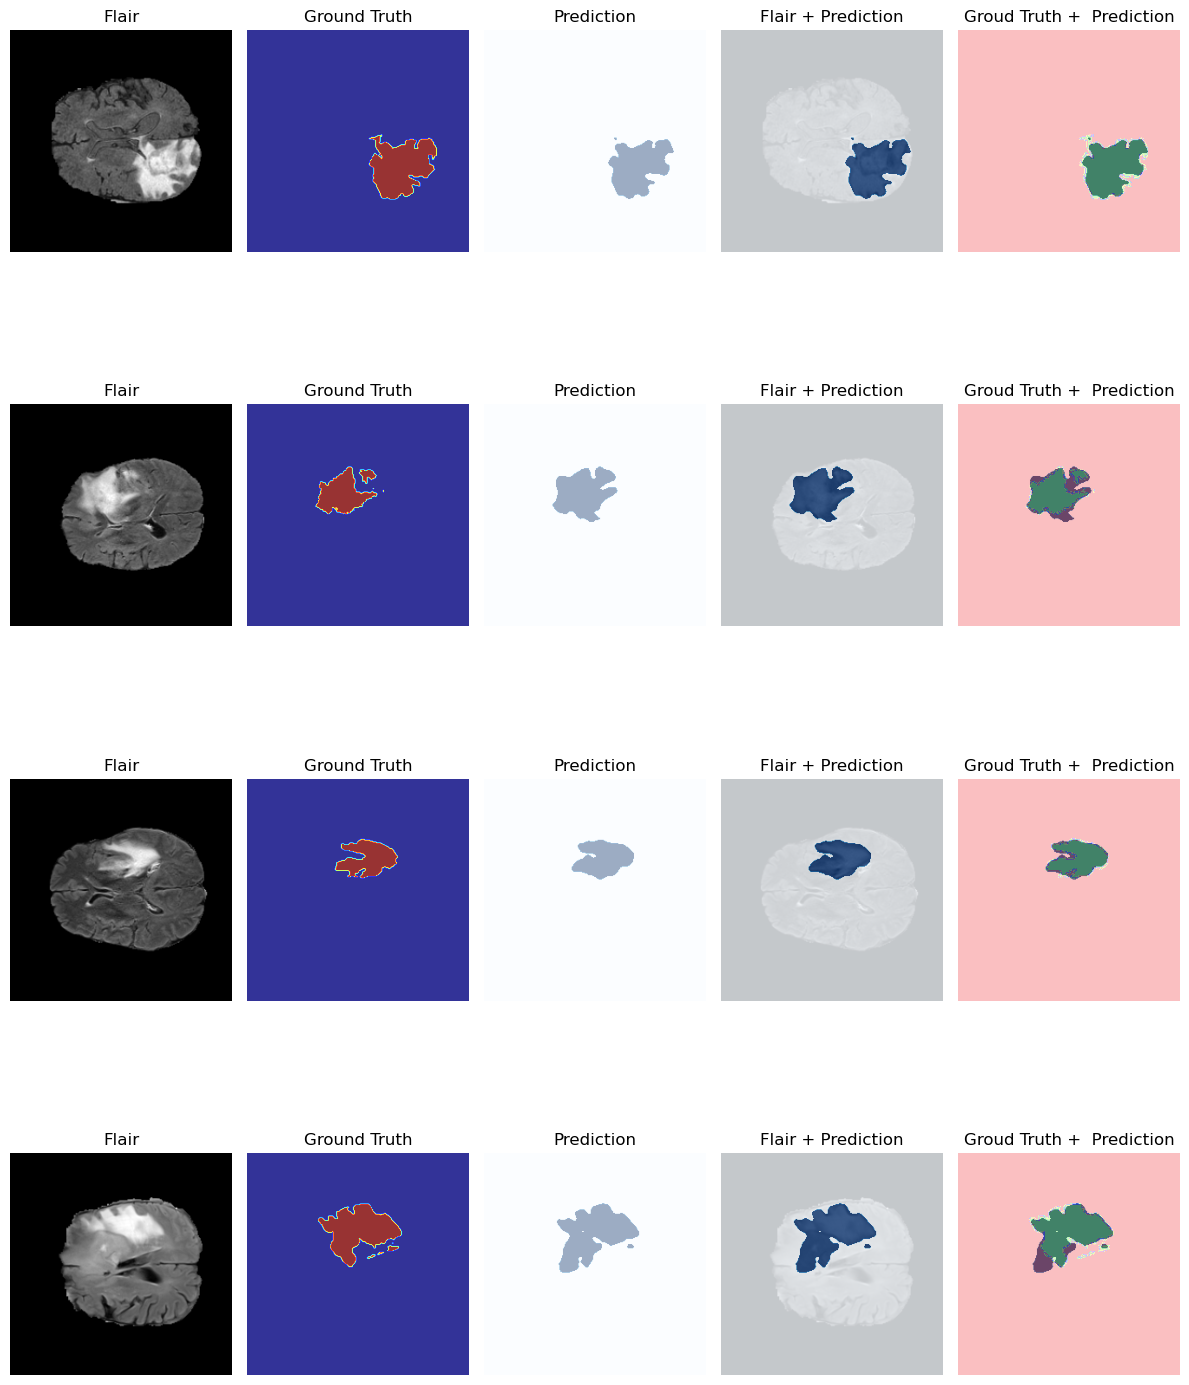

Testing: 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]

Test Combined Loss: 0.5369
Test IOU Score: 0.6736
Test BCE Loss: 0.0417


In [46]:
# validate the model on validation set
test_and_visualize(model, val_loader, device, mode="with_mask")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

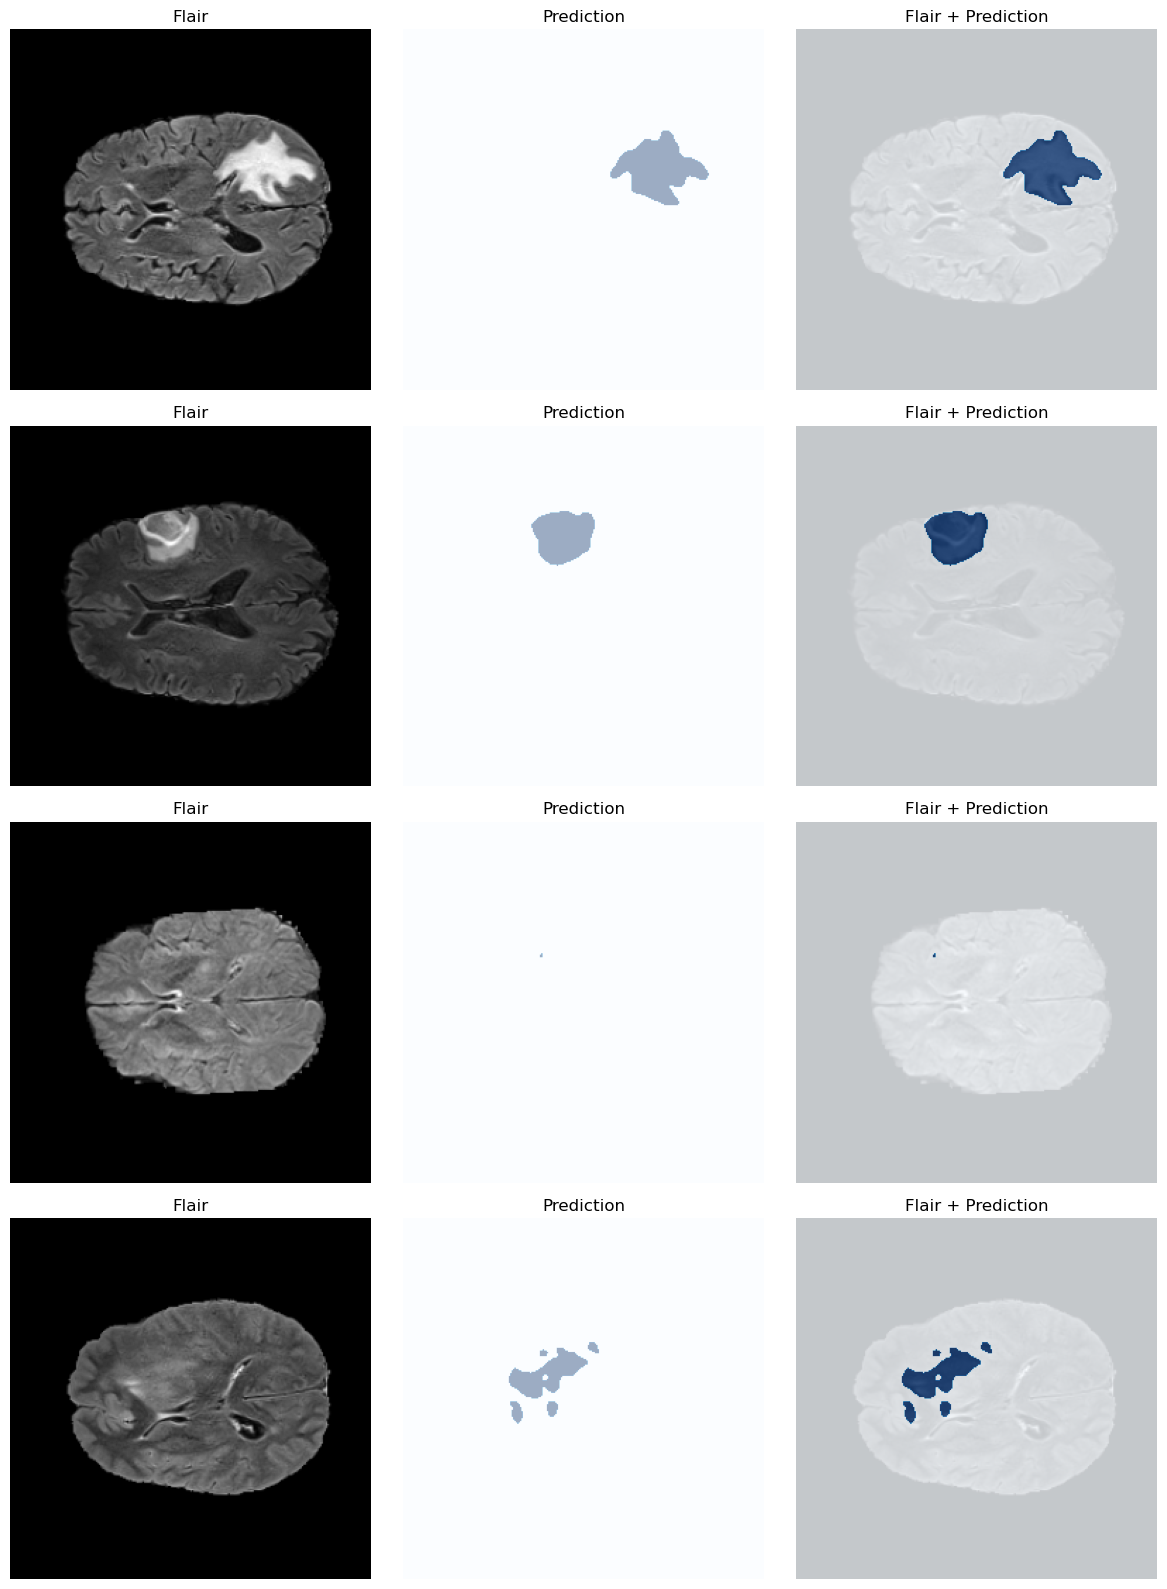

Testing: 100%|██████████| 2/2 [00:17<00:00,  8.86s/it]

Test Combined Loss: 1.7776
Test IOU Score: 0.1445
Test BCE Loss: 0.7776


In [47]:
# validate the model on test set without ground truth mask
test_and_visualize(model, test_loader, device)
